# Import dependencies

In [1]:
import pandas as pd
from plot import line_plot
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from models import SIR,SIRD
from prediction import Predicter
from simulator import simulation
from datetime import timedelta
import numpy as np
from estimator import Estimater
from utilities import select_area, show_trend, create_target_df
%matplotlib inline
plt.rcParams["figure.figsize"] = [10, 5]

# Pre-processing raw data

In [2]:
time_format = "%d%b%Y %H:%M"
datetime.now().strftime(time_format)

raw = pd.read_csv("./data/covid_19_data.csv")
data_cols = ["Infected", "Deaths", "Recovered"]
rate_cols = ["Fatal per Confirmed", "Recovered per Confirmed", "Fatal per (Fatal or Recovered)"]
variable_dict = {"Susceptible": "S", "Infected": "I", "Recovered": "R", "Deaths": "D"}
ncov_df = raw.rename({"ObservationDate": "Date", "Province/State": "Province"}, axis=1)
ncov_df["Date"] = pd.to_datetime(ncov_df["Date"])
ncov_df["Country"] = ncov_df["Country/Region"].replace(
    {
        "Mainland China": "China",
        "Hong Kong SAR": "Hong Kong",
        "Taipei and environs": "Taiwan",
        "Iran (Islamic Republic of)": "Iran",
        "Republic of Korea": "South Korea",
        "Republic of Ireland": "Ireland",
        "Macao SAR": "Macau",
        "Russian Federation": "Russia",
        "Republic of Moldova": "Moldova",
        "Taiwan*": "Taiwan",
        "Cruise Ship": "Others",
        "United Kingdom": "UK",
        "Viet Nam": "Vietnam",
        "Czechia": "Czech Republic",
        "St. Martin": "Saint Martin",
        "Cote d'Ivoire": "Ivory Coast",
        "('St. Martin',)": "Saint Martin",
        "Congo (Kinshasa)": "Congo",
    }
)
ncov_df["Province"] = ncov_df["Province"].fillna("-").replace(
    {
        "Cruise Ship": "Diamond Princess cruise ship",
        "Diamond Princess": "Diamond Princess cruise ship"
    }
)

ncov_df["Infected"] = ncov_df["Confirmed"] - ncov_df["Deaths"] - ncov_df["Recovered"]
ncov_df[data_cols] = ncov_df[data_cols].astype(int)
ncov_df = ncov_df.loc[:, ["Date", "Country", "Province", *data_cols]]
print(ncov_df.tail())
print(ncov_df.info())
ncov_df.describe(include="all").fillna("-")
pd.DataFrame(ncov_df.isnull().sum()).T
", ".join(ncov_df["Country"].unique().tolist())

           Date                         Country                      Province  \
5627 2020-03-14                              US          Virgin Islands, U.S.   
5628 2020-03-14                              UK                     Gibraltar   
5629 2020-03-14                       Australia  Diamond Princess cruise ship   
5630 2020-03-14                              US                 West Virginia   
5631 2020-03-14  occupied Palestinian territory                             -   

      Infected  Deaths  Recovered  
5627         1       0          0  
5628         0       0          1  
5629         0       0          0  
5630         0       0          0  
5631         0       0          0  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5632 entries, 0 to 5631
Data columns (total 6 columns):
Date         5632 non-null datetime64[ns]
Country      5632 non-null object
Province     5632 non-null object
Infected     5632 non-null int64
Deaths       5632 non-null int64
Recovered    56

'China, Hong Kong, Macau, Taiwan, US, Japan, Thailand, South Korea, Singapore, Philippines, Malaysia, Vietnam, Australia, Mexico, Brazil, Colombia, France, Nepal, Canada, Cambodia, Sri Lanka, Ivory Coast, Germany, Finland, United Arab Emirates, India, Italy, UK, Russia, Sweden, Spain, Belgium, Others, Egypt, Iran, Israel, Lebanon, Iraq, Oman, Afghanistan, Bahrain, Kuwait, Austria, Algeria, Croatia, Switzerland, Pakistan, Georgia, Greece, North Macedonia, Norway, Romania, Denmark, Estonia, Netherlands, San Marino,  Azerbaijan, Belarus, Iceland, Lithuania, New Zealand, Nigeria, North Ireland, Ireland, Luxembourg, Monaco, Qatar, Ecuador, Azerbaijan, Czech Republic, Armenia, Dominican Republic, Indonesia, Portugal, Andorra, Latvia, Morocco, Saudi Arabia, Senegal, Argentina, Chile, Jordan, Ukraine, Saint Barthelemy, Hungary, Faroe Islands, Gibraltar, Liechtenstein, Poland, Tunisia, Palestine, Bosnia and Herzegovina, Slovenia, South Africa, Bhutan, Cameroon, Costa Rica, Peru, Serbia, Slovaki

# Visualize data for the world

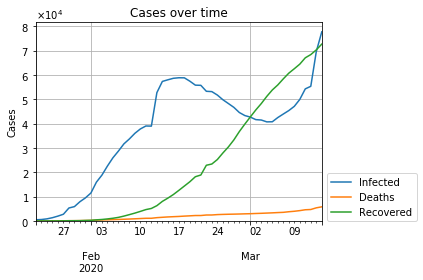

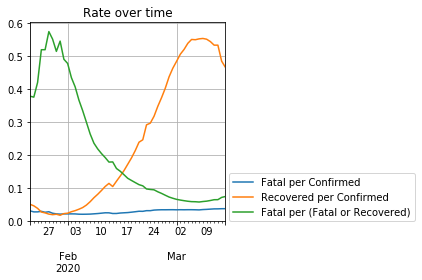

In [3]:
total_df = ncov_df.groupby("Date").sum()
total_df[rate_cols[0]] = total_df["Deaths"] / total_df[data_cols].sum(axis=1)
total_df[rate_cols[1]] = total_df["Recovered"] / total_df[data_cols].sum(axis=1)
total_df[rate_cols[2]] = total_df["Deaths"] / (total_df["Deaths"] + total_df["Recovered"])
total_df.tail()
pd.plotting.register_matplotlib_converters()
line_plot(total_df[data_cols], title="Cases over time")
line_plot(total_df[rate_cols], "Rate over time", ylabel="", math_scale=False)
plt.show()

# Visualize data for Norway

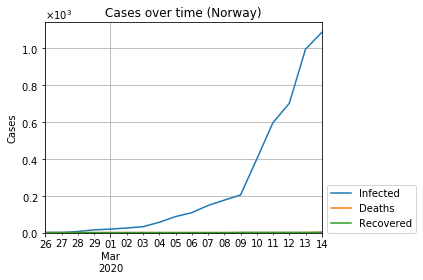

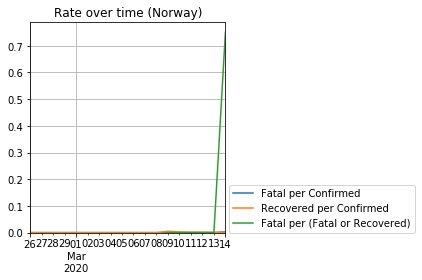

In [4]:
total_df = ncov_df.loc[ncov_df["Country"] == "Norway", :].groupby("Date").sum()
total_df[rate_cols[0]] = total_df["Deaths"] / total_df[data_cols].sum(axis=1)
total_df[rate_cols[1]] = total_df["Recovered"] / total_df[data_cols].sum(axis=1)
total_df[rate_cols[2]] = total_df["Deaths"] / (total_df["Deaths"] + total_df["Recovered"])
total_df.tail()
line_plot(total_df[data_cols], title="Cases over time (Norway)")
line_plot(total_df[rate_cols], "Rate over time (Norway)", ylabel="", math_scale=False)
plt.show()

In [5]:
population_date = "15Mar2020"
_dict = {
    "Global": "7,794,798,729",
    "China": "1,439,323,774",
    "Japan": "126,476,458",
    "South Korea": "51,269,182",
    "Italy": "60,461,827",
    "Iran": "83,992,953",
    "Norway":"5,421,241",
    "India": "1,380,004,385",
    "USA": "331,002,647",

}
population_dict = {k: int(v.replace(",", "")) for (k, v) in _dict.items()}
df = pd.io.json.json_normalize(population_dict)
df.index = [f"Total population on {population_date}"]
df

,Global,China,Japan,South Korea,Italy,Iran,Norway,India,USA
Total population on 15Mar2020,7794798729,1439323774,126476458,51269182,60461827,83992953,5421241,1380004385,331002647


# Prediction with SIR model

## The SIR epidemic model

A simple mathematical description of the spread of a disease in a population is the so-called SIR model, which divides the (fixed) population of $N$ individuals into three "compartments" which may vary as a function of time, $t$:

 * $S(t)$: Susceptible       (= All - Confirmed)
 * $I(t)$: Infected          (= Confirmed - Recovered - Deaths)
 * $R(t)$: Recovered or Died (= Recovered + Deaths)
 
 

The SIR model describes the change in the population of each of these compartments in terms of two parameters, $\beta$ and $\gamma$. 

* $\beta$ describes the effective contact rate of the disease: an infected individual comes into contact with $\beta N$ other individuals per unit time (of which the fraction that are susceptible to contracting the disease is $S/N$). 

* $\gamma$ is the mean recovery rate: that is, $1/\gamma$ is the mean period of time during which an infected individual can pass it on.

The differential equations describing this model were first derived by Kermack and McKendrick [Proc. R. Soc. A, 115, 772 (1927)]:


$$\frac{dS}{dT}=\frac{-\beta}{N}SI$$

$$\frac{dI}{dT}=\frac{\beta SI}{N}-\gamma I$$

$$\frac{dR}{dT}=\gamma I$$

Where $N=S+I+R$ is the total population, $T$ is the elapsed time from the start date.

<a href="https://scipython.com/book/chapter-8-scipy/additional-examples/the-sir-epidemic-model/">Sample code</a>


## Non-dimensional SIR model
To simplify the model, the units of the variables should be removed from ODE.

Set $(S, I, R) = N \times (x, y, z)$ and $(T, \beta, \gamma) = (\tau t, \tau^{-1} \rho, \tau^{-1} \sigma)$.  

This results in the ODE  
$$\frac{dx}{dt}= - \rho x y$$  
$$\frac{dy}{dt}= \rho x y - \sigma y$$  
$$\frac{dz}{dt}= \sigma y$$

Where $N$ is the total population and $\tau$ is a coefficient ([min], is an integer to simplify).  

The range of variables and parameters:  
$0 < (x, y, z, \rho, \sigma) < 1$  
$1\leq \tau \leq 1440$  

Basic reproduction number, Non-dimentional parameter, is defined as  
$R_0 = \rho \sigma^{-1} = \beta \gamma^{-1}$  

Estimated Mean Values of $R_0$:  
$R_0$ means "the average number of secondary infections caused by an infected host" ([Infection Modeling — Part 1](https://towardsdatascience.com/infection-modeling-part-1-87e74645568a)).  
(Secondary data: [Van den Driessche, P., & Watmough, J. (2002).](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6002118))  
2.06: Zika in South America, 2015-2016  
1.51: Ebola in Guinea, 2014  
1.33: H1N1 influenza in South Africa, 2009  
3.5 : SARS in 2002-2003
1.68: H2N2 influenza in US, 1957  
3.8 : Fall wave of 1918 Spanish influenza in Genova
1.5 : Spring wave of 1918 Spanish influenza in Genova

In [6]:
train_dataset = SIR.create_dataset(
    ncov_df, population_dict["Global"] - population_dict["China"], excluded_places=[("China", None)]
)
train_start_date, train_initials, train_Tend, train_df = train_dataset
print([train_start_date.strftime(time_format), train_initials, train_Tend])

['22Jan2020 00:00', array([9.99999999e-01, 1.25875722e-09, 0.00000000e+00]), 74880]


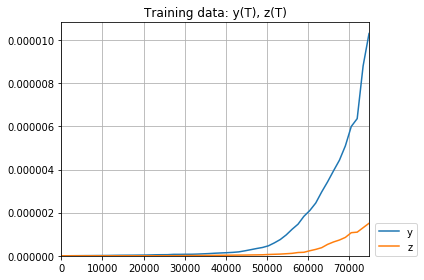

In [7]:
line_plot(
    train_df.set_index("T").drop("x", axis=1),
    "Training data: y(T), z(T)", math_scale=False, ylabel=""
)

**Note: We cannot convert $T$ to $t$ because $\tau$ has not been determined yet.**

### Example of non-dimensional SIR model
For example, set $R_0 = 2.5, \rho=0.2$.

In [8]:
eg_r0, eg_rho = (2.5, 0.2)
eg_sigma = eg_rho / eg_r0

In [9]:
%%time
eg_df = simulation(SIR, train_initials, step_n=300, rho=eg_rho, sigma=eg_sigma)
eg_df.tail()

CPU times: user 10.5 ms, sys: 3.93 ms, total: 14.5 ms
Wall time: 14 ms


,t,x,y,z
296,296,0.108343,0.000628,0.891029
297,297,0.108330,0.000592,0.891078
298,298,0.108317,0.000559,0.891124
299,299,0.108306,0.000527,0.891167
300,300,0.108295,0.000497,0.891208


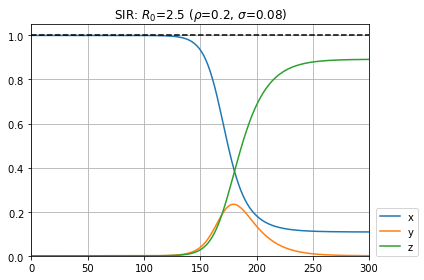

In [14]:
line_plot(
    eg_df.set_index("t"),
    title=r"SIR: $R_0$={0} ($\rho$={1}, $\sigma$={2})".format(eg_r0, eg_rho, eg_sigma),
    ylabel="",
    h=1
)

### Test of hyperparameter optimization using example data
To test the hyperparameter optimization functions defeined in this notebook, we will estimate the SIR model parameters using the example data and example $\tau=1440$ [min] and total population 1,000,000.

In [11]:
# Set the example conditions
#eg_tau = 1440
#eg_start_date = ncov_df["Date"].min()
#eg_total_population = 1000000
# Create dataset in the format of ncov_df
#eg_ori_df = pd.DataFrame(
#    {
#        "Date": (eg_df["t"] * eg_tau).apply(lambda x: timedelta(minutes=x)) + eg_start_date,
#        "Country": "Example",
#        "Province": "Example"
#    }
#)
#eg_ori_df["Infected"] = (eg_df["y"] * eg_total_population).astype(int)
#eg_ori_df["Deaths"] = (eg_df["z"] * eg_total_population * 0.02).astype(int)
#eg_ori_df["Recovered"] = (eg_df["z"] * eg_total_population * 0.98).astype(int)
#eg_ori_df.tail()

### Hyperparameter optimization
Using Optuna package, ($\rho, \sigma, \tau$) will be estimated by model fitting.

In [12]:
%%time
sir_estimater = Estimater(
    SIR, ncov_df, population_dict["Global"] - population_dict["China"],
    name="Total except China", excluded_places=[("China", None)]
)
sir_dict = sir_estimater.run()

[I 2020-03-16 09:47:59,088] Finished trial#1 resulted in value: 10600119892.83568. Current best value is 10600119892.83568 with parameters: {'tau': 1102, 'rho': 0.10863309736771407, 'sigma': 0.008325749864543958}.
[I 2020-03-16 09:47:59,160] Finished trial#2 resulted in value: 8733096535.122877. Current best value is 8733096535.122877 with parameters: {'tau': 537, 'rho': 0.06714308367193476, 'sigma': 0.007052358348800447}.
[I 2020-03-16 09:47:59,326] Finished trial#0 resulted in value: 5941178491.188844. Current best value is 5941178491.188844 with parameters: {'tau': 26, 'rho': 0.003522137793959376, 'sigma': 0.00036246721235061945}.
[I 2020-03-16 09:47:59,398] Finished trial#5 resulted in value: 19781486926.99033. Current best value is 5941178491.188844 with parameters: {'tau': 26, 'rho': 0.003522137793959376, 'sigma': 0.00036246721235061945}.
[I 2020-03-16 09:47:59,472] Finished trial#3 resulted in value: 8998739888.704021. Current best value is 5941178491.188844 with parameters: {'t

[I 2020-03-16 09:48:03,925] Finished trial#38 resulted in value: 5117662482.229936. Current best value is 3713567096.9380546 with parameters: {'tau': 1422, 'rho': 0.19858720807069907, 'sigma': 0.02520816460218655}.
[I 2020-03-16 09:48:04,032] Finished trial#39 resulted in value: 4944840273.741755. Current best value is 3713567096.9380546 with parameters: {'tau': 1422, 'rho': 0.19858720807069907, 'sigma': 0.02520816460218655}.
[I 2020-03-16 09:48:04,238] Finished trial#42 resulted in value: 4825451704.023776. Current best value is 3713567096.9380546 with parameters: {'tau': 1422, 'rho': 0.19858720807069907, 'sigma': 0.02520816460218655}.
[I 2020-03-16 09:48:04,350] Finished trial#41 resulted in value: 4316778313.047481. Current best value is 3713567096.9380546 with parameters: {'tau': 1422, 'rho': 0.19858720807069907, 'sigma': 0.02520816460218655}.
[I 2020-03-16 09:48:04,462] Finished trial#43 resulted in value: 5491775129.323398. Current best value is 3713567096.9380546 with parameters

[I 2020-03-16 09:48:09,850] Finished trial#76 resulted in value: 4122132467.3975143. Current best value is 3635678179.824568 with parameters: {'tau': 1362, 'rho': 0.19467635948430884, 'sigma': 0.024340015433463646}.
[I 2020-03-16 09:48:10,049] Finished trial#79 resulted in value: 3821825990.2392006. Current best value is 3635678179.824568 with parameters: {'tau': 1362, 'rho': 0.19467635948430884, 'sigma': 0.024340015433463646}.
[I 2020-03-16 09:48:10,116] Finished trial#77 resulted in value: 3695882571.5473595. Current best value is 3635678179.824568 with parameters: {'tau': 1362, 'rho': 0.19467635948430884, 'sigma': 0.024340015433463646}.
[I 2020-03-16 09:48:10,126] Finished trial#78 resulted in value: 3936988213.1247115. Current best value is 3635678179.824568 with parameters: {'tau': 1362, 'rho': 0.19467635948430884, 'sigma': 0.024340015433463646}.
[I 2020-03-16 09:48:10,349] Finished trial#80 resulted in value: 5310533303.054365. Current best value is 3635678179.824568 with paramet

[I 2020-03-16 09:48:15,680] Finished trial#114 resulted in value: 3800723339.655413. Current best value is 3561229073.4211364 with parameters: {'tau': 1371, 'rho': 0.19395431813453354, 'sigma': 0.023405424330669253}.
[I 2020-03-16 09:48:15,812] Finished trial#116 resulted in value: 4226180563.4703984. Current best value is 3561229073.4211364 with parameters: {'tau': 1371, 'rho': 0.19395431813453354, 'sigma': 0.023405424330669253}.
[I 2020-03-16 09:48:15,964] Finished trial#117 resulted in value: 4307701826.2532. Current best value is 3561229073.4211364 with parameters: {'tau': 1371, 'rho': 0.19395431813453354, 'sigma': 0.023405424330669253}.
[I 2020-03-16 09:48:16,098] Finished trial#118 resulted in value: 4108580652.1765428. Current best value is 3561229073.4211364 with parameters: {'tau': 1371, 'rho': 0.19395431813453354, 'sigma': 0.023405424330669253}.
[I 2020-03-16 09:48:16,253] Finished trial#120 resulted in value: 4612980874.865237. Current best value is 3561229073.4211364 with p

[I 2020-03-16 09:48:20,814] Finished trial#151 resulted in value: 3722332022.6236534. Current best value is 3454871357.3774095 with parameters: {'tau': 1407, 'rho': 0.19862382065484616, 'sigma': 0.024533023329719624}.
[I 2020-03-16 09:48:20,885] Finished trial#152 resulted in value: 3890888210.366636. Current best value is 3454871357.3774095 with parameters: {'tau': 1407, 'rho': 0.19862382065484616, 'sigma': 0.024533023329719624}.
[I 2020-03-16 09:48:21,054] Finished trial#149 resulted in value: 4151806968.770142. Current best value is 3454871357.3774095 with parameters: {'tau': 1407, 'rho': 0.19862382065484616, 'sigma': 0.024533023329719624}.
[I 2020-03-16 09:48:21,207] Finished trial#155 resulted in value: 3968371539.4821734. Current best value is 3454871357.3774095 with parameters: {'tau': 1407, 'rho': 0.19862382065484616, 'sigma': 0.024533023329719624}.
[I 2020-03-16 09:48:21,315] Finished trial#154 resulted in value: 4001420717.592192. Current best value is 3454871357.3774095 with

[I 2020-03-16 09:48:26,534] Finished trial#188 resulted in value: 4144196789.4338284. Current best value is 3454871357.3774095 with parameters: {'tau': 1407, 'rho': 0.19862382065484616, 'sigma': 0.024533023329719624}.
[I 2020-03-16 09:48:26,733] Finished trial#189 resulted in value: 4352689985.374372. Current best value is 3454871357.3774095 with parameters: {'tau': 1407, 'rho': 0.19862382065484616, 'sigma': 0.024533023329719624}.
[I 2020-03-16 09:48:26,846] Finished trial#190 resulted in value: 4269543081.717933. Current best value is 3454871357.3774095 with parameters: {'tau': 1407, 'rho': 0.19862382065484616, 'sigma': 0.024533023329719624}.
[I 2020-03-16 09:48:27,015] Finished trial#192 resulted in value: 4043765680.562817. Current best value is 3454871357.3774095 with parameters: {'tau': 1407, 'rho': 0.19862382065484616, 'sigma': 0.024533023329719624}.
[I 2020-03-16 09:48:27,129] Finished trial#193 resulted in value: 3692590002.7599483. Current best value is 3454871357.3774095 with

[I 2020-03-16 09:48:32,379] Finished trial#226 resulted in value: 4141888826.391637. Current best value is 3454871357.3774095 with parameters: {'tau': 1407, 'rho': 0.19862382065484616, 'sigma': 0.024533023329719624}.
[I 2020-03-16 09:48:32,553] Finished trial#199 resulted in value: 9388453284.853104. Current best value is 3454871357.3774095 with parameters: {'tau': 1407, 'rho': 0.19862382065484616, 'sigma': 0.024533023329719624}.
[I 2020-03-16 09:48:32,694] Finished trial#227 resulted in value: 3949879387.4976106. Current best value is 3454871357.3774095 with parameters: {'tau': 1407, 'rho': 0.19862382065484616, 'sigma': 0.024533023329719624}.
[I 2020-03-16 09:48:32,805] Finished trial#228 resulted in value: 4297794711.217832. Current best value is 3454871357.3774095 with parameters: {'tau': 1407, 'rho': 0.19862382065484616, 'sigma': 0.024533023329719624}.
[I 2020-03-16 09:48:33,027] Finished trial#229 resulted in value: 4080895980.6334705. Current best value is 3454871357.3774095 with

[I 2020-03-16 09:48:38,330] Finished trial#262 resulted in value: 3984558940.256647. Current best value is 3454871357.3774095 with parameters: {'tau': 1407, 'rho': 0.19862382065484616, 'sigma': 0.024533023329719624}.
[I 2020-03-16 09:48:38,513] Finished trial#264 resulted in value: 4783609902.254802. Current best value is 3454871357.3774095 with parameters: {'tau': 1407, 'rho': 0.19862382065484616, 'sigma': 0.024533023329719624}.
[I 2020-03-16 09:48:38,632] Finished trial#263 resulted in value: 4653470885.354633. Current best value is 3454871357.3774095 with parameters: {'tau': 1407, 'rho': 0.19862382065484616, 'sigma': 0.024533023329719624}.
[I 2020-03-16 09:48:39,101] Finished trial#265 resulted in value: 3839160674.333746. Current best value is 3454871357.3774095 with parameters: {'tau': 1407, 'rho': 0.19862382065484616, 'sigma': 0.024533023329719624}.
[I 2020-03-16 09:48:39,101] Finished trial#266 resulted in value: 4329222216.694775. Current best value is 3454871357.3774095 with p

[I 2020-03-16 09:48:45,285] Finished trial#298 resulted in value: 4087425524.27523. Current best value is 3454871357.3774095 with parameters: {'tau': 1407, 'rho': 0.19862382065484616, 'sigma': 0.024533023329719624}.
[I 2020-03-16 09:48:45,505] Finished trial#290 resulted in value: 8688885595.974138. Current best value is 3454871357.3774095 with parameters: {'tau': 1407, 'rho': 0.19862382065484616, 'sigma': 0.024533023329719624}.
[I 2020-03-16 09:48:45,627] Finished trial#300 resulted in value: 3874936026.654244. Current best value is 3454871357.3774095 with parameters: {'tau': 1407, 'rho': 0.19862382065484616, 'sigma': 0.024533023329719624}.
[I 2020-03-16 09:48:45,709] Finished trial#301 resulted in value: 7586522417.875723. Current best value is 3454871357.3774095 with parameters: {'tau': 1407, 'rho': 0.19862382065484616, 'sigma': 0.024533023329719624}.
[I 2020-03-16 09:48:45,966] Finished trial#304 resulted in value: 3751520455.5346346. Current best value is 3454871357.3774095 with p

[I 2020-03-16 09:48:51,339] Finished trial#335 resulted in value: 4682864627.255708. Current best value is 3454871357.3774095 with parameters: {'tau': 1407, 'rho': 0.19862382065484616, 'sigma': 0.024533023329719624}.
[I 2020-03-16 09:48:51,519] Finished trial#339 resulted in value: 3888108038.6692276. Current best value is 3454871357.3774095 with parameters: {'tau': 1407, 'rho': 0.19862382065484616, 'sigma': 0.024533023329719624}.
[I 2020-03-16 09:48:51,686] Finished trial#340 resulted in value: 4017522967.818022. Current best value is 3454871357.3774095 with parameters: {'tau': 1407, 'rho': 0.19862382065484616, 'sigma': 0.024533023329719624}.
[I 2020-03-16 09:48:51,863] Finished trial#330 resulted in value: 10411733487.921232. Current best value is 3454871357.3774095 with parameters: {'tau': 1407, 'rho': 0.19862382065484616, 'sigma': 0.024533023329719624}.
[I 2020-03-16 09:48:51,981] Finished trial#341 resulted in value: 3945230427.3602204. Current best value is 3454871357.3774095 wit

[I 2020-03-16 09:48:58,206] Finished trial#374 resulted in value: 4069682430.9656806. Current best value is 3454871357.3774095 with parameters: {'tau': 1407, 'rho': 0.19862382065484616, 'sigma': 0.024533023329719624}.
[I 2020-03-16 09:48:58,413] Finished trial#376 resulted in value: 3953660491.372708. Current best value is 3454871357.3774095 with parameters: {'tau': 1407, 'rho': 0.19862382065484616, 'sigma': 0.024533023329719624}.
[I 2020-03-16 09:48:58,580] Finished trial#375 resulted in value: 3877727500.605617. Current best value is 3454871357.3774095 with parameters: {'tau': 1407, 'rho': 0.19862382065484616, 'sigma': 0.024533023329719624}.
[I 2020-03-16 09:48:58,771] Finished trial#378 resulted in value: 3744245422.1593103. Current best value is 3454871357.3774095 with parameters: {'tau': 1407, 'rho': 0.19862382065484616, 'sigma': 0.024533023329719624}.
[I 2020-03-16 09:48:58,956] Finished trial#379 resulted in value: 4772050660.375889. Current best value is 3454871357.3774095 with

[I 2020-03-16 09:49:04,663] Finished trial#410 resulted in value: 3590609925.7950544. Current best value is 3454871357.3774095 with parameters: {'tau': 1407, 'rho': 0.19862382065484616, 'sigma': 0.024533023329719624}.
[I 2020-03-16 09:49:04,872] Finished trial#412 resulted in value: 3989721528.1965227. Current best value is 3454871357.3774095 with parameters: {'tau': 1407, 'rho': 0.19862382065484616, 'sigma': 0.024533023329719624}.
[I 2020-03-16 09:49:04,993] Finished trial#413 resulted in value: 3700668365.0832705. Current best value is 3454871357.3774095 with parameters: {'tau': 1407, 'rho': 0.19862382065484616, 'sigma': 0.024533023329719624}.
[I 2020-03-16 09:49:05,148] Finished trial#398 resulted in value: 8772881993.600594. Current best value is 3454871357.3774095 with parameters: {'tau': 1407, 'rho': 0.19862382065484616, 'sigma': 0.024533023329719624}.
[I 2020-03-16 09:49:05,370] Finished trial#415 resulted in value: 3818955894.1186795. Current best value is 3454871357.3774095 wi

[I 2020-03-16 09:49:10,946] Finished trial#449 resulted in value: 3870065897.941959. Current best value is 3454871357.3774095 with parameters: {'tau': 1407, 'rho': 0.19862382065484616, 'sigma': 0.024533023329719624}.
[I 2020-03-16 09:49:11,031] Finished trial#448 resulted in value: 3740220804.6648526. Current best value is 3454871357.3774095 with parameters: {'tau': 1407, 'rho': 0.19862382065484616, 'sigma': 0.024533023329719624}.
[I 2020-03-16 09:49:11,223] Finished trial#447 resulted in value: 3820667356.973916. Current best value is 3454871357.3774095 with parameters: {'tau': 1407, 'rho': 0.19862382065484616, 'sigma': 0.024533023329719624}.
[I 2020-03-16 09:49:11,476] Finished trial#451 resulted in value: 3968707969.6887. Current best value is 3454871357.3774095 with parameters: {'tau': 1407, 'rho': 0.19862382065484616, 'sigma': 0.024533023329719624}.
[I 2020-03-16 09:49:11,547] Finished trial#450 resulted in value: 3964587490.8090606. Current best value is 3454871357.3774095 with p

[I 2020-03-16 09:49:17,618] Finished trial#486 resulted in value: 5244510796.638785. Current best value is 3454871357.3774095 with parameters: {'tau': 1407, 'rho': 0.19862382065484616, 'sigma': 0.024533023329719624}.
[I 2020-03-16 09:49:17,836] Finished trial#487 resulted in value: 3625517736.4631147. Current best value is 3454871357.3774095 with parameters: {'tau': 1407, 'rho': 0.19862382065484616, 'sigma': 0.024533023329719624}.
[I 2020-03-16 09:49:18,022] Finished trial#480 resulted in value: 5175012547.638885. Current best value is 3454871357.3774095 with parameters: {'tau': 1407, 'rho': 0.19862382065484616, 'sigma': 0.024533023329719624}.
[I 2020-03-16 09:49:18,193] Finished trial#488 resulted in value: 3968049688.412362. Current best value is 3454871357.3774095 with parameters: {'tau': 1407, 'rho': 0.19862382065484616, 'sigma': 0.024533023329719624}.
[I 2020-03-16 09:49:18,361] Finished trial#483 resulted in value: 9841154437.561972. Current best value is 3454871357.3774095 with 

CPU times: user 1min 19s, sys: 4.06 s, total: 1min 23s
Wall time: 1min 21s


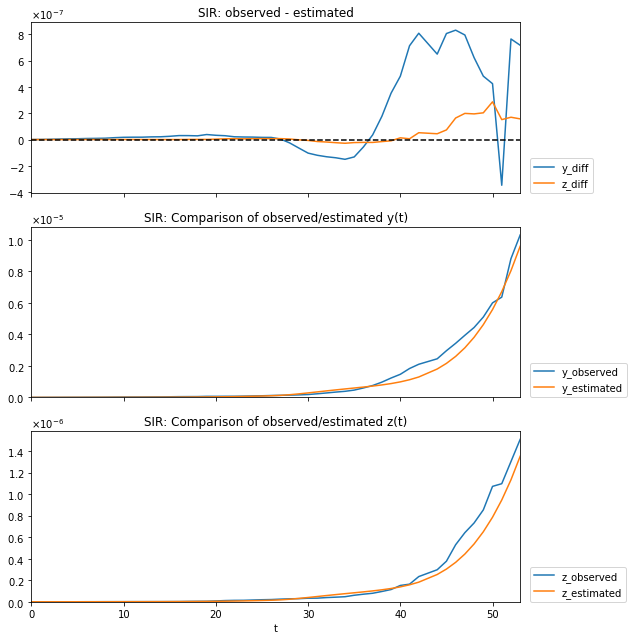

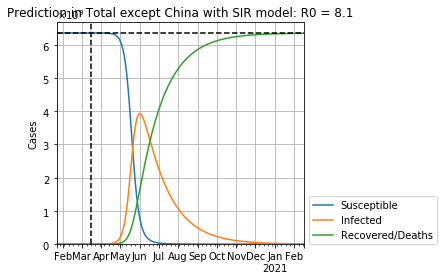

In [15]:
sir_estimater.history_df().head()
#sir_estimater.history_graph()
pd.DataFrame.from_dict({"SIR": sir_dict}, orient="index")
sir_estimater.compare_graph()
sir_estimater.predict_graph(step_n=400)

## Prediction with SIR-D model
Because we can measure the number of fatal cases and recovered cases separately, we can use two variables ("Recovered" and "Deaths") instead of "Recovered + Deaths" in the mathematical model.

### What is SIR-D model?
* S: Susceptible
* I: Infected
* R: Recovered
* D: Fatal

Model:  
S + I $\overset{\beta}{\longrightarrow}$ 2I  
I $\overset{\gamma}{\longrightarrow}$ R  
I $\overset{\alpha}{\longrightarrow}$ D  

$\alpha$: Mortality rate [1/min]  
$\beta$: Effective contact rate [1/min]  
$\gamma$: Recovery rate [1/min]  

Ordinary Differential Equation (ODE):   
$\frac{\mathrm{d}S}{\mathrm{d}T}= - N^{-1}\beta S I$  
$\frac{\mathrm{d}I}{\mathrm{d}T}= N^{-1}\beta S I - (\gamma + \alpha) I$  
$\frac{\mathrm{d}R}{\mathrm{d}T}= \gamma I$  
$\frac{\mathrm{d}D}{\mathrm{d}T}= \alpha I$  

Where $N=S+I+R+D$ is the total population, $T$ is the elapsed time from the start date.

### Non-dimensional SIR-D model
Set $(S, I, R, D) = N \times (x, y, z, z)$ and $(T, \alpha, \beta, \gamma) = (\tau t, \tau^{-1} \kappa, \tau^{-1} \rho, \tau^{-1} \sigma)$.  
This results in the ODE  
$\frac{\mathrm{d}x}{\mathrm{d}t}= - \rho x y$  
$\frac{\mathrm{d}y}{\mathrm{d}t}= \rho x y - (\sigma + \kappa) y$  
$\frac{\mathrm{d}z}{\mathrm{d}t}= \sigma y$  
$\frac{\mathrm{d}w}{\mathrm{d}t}= \kappa y$  

Where $N$ is the total population and $\tau$ is a coefficient ([min], is an integer to simplify).  

The range of variables and parameters:  
$0 < (x, y, z, \kappa, \rho, \sigma) < 1$  
$1\leq \tau \leq 1440$

Reproduction number can be defined as  
$R_0 = \rho (\sigma + \kappa)^{-1} = \beta (\gamma + \alpha)^{-1}$

### Hyperparameter optimization
Using Optuna package, ($\kappa, \rho, \sigma, \tau$) will be estimated by model fitting.

In [16]:
%%time
sird_estimater = Estimater(
    SIRD, ncov_df, population_dict["Global"] - population_dict["China"],
    name="Total except China", excluded_places=[("China", None)]
)
sird_dict = sird_estimater.run()

[I 2020-03-16 09:52:41,018] Finished trial#3 resulted in value: 108145906657.01282. Current best value is 108145906657.01282 with parameters: {'tau': 1387, 'kappa': 0.0029002534504299123, 'rho': 0.14605042607926927, 'sigma': 0.0138867183942019}.
[I 2020-03-16 09:52:41,156] Finished trial#2 resulted in value: 171683798218.5996. Current best value is 108145906657.01282 with parameters: {'tau': 1387, 'kappa': 0.0029002534504299123, 'rho': 0.14605042607926927, 'sigma': 0.0138867183942019}.
[I 2020-03-16 09:52:41,243] Finished trial#0 resulted in value: 57443436466.58139. Current best value is 57443436466.58139 with parameters: {'tau': 1357, 'kappa': 0.0016780849674127994, 'rho': 0.19371665719061815, 'sigma': 0.013365339570831317}.
[I 2020-03-16 09:52:41,311] Finished trial#1 resulted in value: 114494433297.3995. Current best value is 57443436466.58139 with parameters: {'tau': 1357, 'kappa': 0.0016780849674127994, 'rho': 0.19371665719061815, 'sigma': 0.013365339570831317}.
[I 2020-03-16 09:

[I 2020-03-16 09:52:45,881] Finished trial#33 resulted in value: 41650713875.880135. Current best value is 41372337193.33338 with parameters: {'tau': 1434, 'kappa': 0.0026407627420689853, 'rho': 0.19773528023704812, 'sigma': 0.020324186616654725}.
[I 2020-03-16 09:52:46,063] Finished trial#34 resulted in value: 47391975422.51201. Current best value is 41372337193.33338 with parameters: {'tau': 1434, 'kappa': 0.0026407627420689853, 'rho': 0.19773528023704812, 'sigma': 0.020324186616654725}.
[I 2020-03-16 09:52:46,174] Finished trial#35 resulted in value: 47121921692.41097. Current best value is 41372337193.33338 with parameters: {'tau': 1434, 'kappa': 0.0026407627420689853, 'rho': 0.19773528023704812, 'sigma': 0.020324186616654725}.
[I 2020-03-16 09:52:46,306] Finished trial#36 resulted in value: 52857153356.39079. Current best value is 41372337193.33338 with parameters: {'tau': 1434, 'kappa': 0.0026407627420689853, 'rho': 0.19773528023704812, 'sigma': 0.020324186616654725}.
[I 2020-03-

[I 2020-03-16 09:52:51,099] Finished trial#66 resulted in value: 39568284804.32631. Current best value is 39568284804.32631 with parameters: {'tau': 1400, 'kappa': 0.002142019183964408, 'rho': 0.19486394193487586, 'sigma': 0.01957209582062216}.
[I 2020-03-16 09:52:51,468] Finished trial#68 resulted in value: 61118069820.58744. Current best value is 39568284804.32631 with parameters: {'tau': 1400, 'kappa': 0.002142019183964408, 'rho': 0.19486394193487586, 'sigma': 0.01957209582062216}.
[I 2020-03-16 09:52:51,717] Finished trial#70 resulted in value: 55747540124.40594. Current best value is 39568284804.32631 with parameters: {'tau': 1400, 'kappa': 0.002142019183964408, 'rho': 0.19486394193487586, 'sigma': 0.01957209582062216}.
[I 2020-03-16 09:52:51,995] Finished trial#67 resulted in value: 109822206187.30568. Current best value is 39568284804.32631 with parameters: {'tau': 1400, 'kappa': 0.002142019183964408, 'rho': 0.19486394193487586, 'sigma': 0.01957209582062216}.
[I 2020-03-16 09:52

[I 2020-03-16 09:52:56,602] Finished trial#98 resulted in value: 41063281709.40821. Current best value is 39568284804.32631 with parameters: {'tau': 1400, 'kappa': 0.002142019183964408, 'rho': 0.19486394193487586, 'sigma': 0.01957209582062216}.
[I 2020-03-16 09:52:56,799] Finished trial#100 resulted in value: 46101417309.668755. Current best value is 39568284804.32631 with parameters: {'tau': 1400, 'kappa': 0.002142019183964408, 'rho': 0.19486394193487586, 'sigma': 0.01957209582062216}.
[I 2020-03-16 09:52:56,916] Finished trial#101 resulted in value: 38865317938.46828. Current best value is 38865317938.46828 with parameters: {'tau': 1407, 'kappa': 0.0017647150427249163, 'rho': 0.1983297221145692, 'sigma': 0.01955928896211723}.
[I 2020-03-16 09:52:57,134] Finished trial#105 resulted in value: 65749546143.71097. Current best value is 38865317938.46828 with parameters: {'tau': 1407, 'kappa': 0.0017647150427249163, 'rho': 0.1983297221145692, 'sigma': 0.01955928896211723}.
[I 2020-03-16 09

[I 2020-03-16 09:53:02,286] Finished trial#135 resulted in value: 43882101451.82997. Current best value is 38865317938.46828 with parameters: {'tau': 1407, 'kappa': 0.0017647150427249163, 'rho': 0.1983297221145692, 'sigma': 0.01955928896211723}.
[I 2020-03-16 09:53:02,452] Finished trial#133 resulted in value: 121699392059.6831. Current best value is 38865317938.46828 with parameters: {'tau': 1407, 'kappa': 0.0017647150427249163, 'rho': 0.1983297221145692, 'sigma': 0.01955928896211723}.
[I 2020-03-16 09:53:02,774] Finished trial#136 resulted in value: 40300571052.56783. Current best value is 38865317938.46828 with parameters: {'tau': 1407, 'kappa': 0.0017647150427249163, 'rho': 0.1983297221145692, 'sigma': 0.01955928896211723}.
[I 2020-03-16 09:53:02,968] Finished trial#138 resulted in value: 49302471356.814865. Current best value is 38865317938.46828 with parameters: {'tau': 1407, 'kappa': 0.0017647150427249163, 'rho': 0.1983297221145692, 'sigma': 0.01955928896211723}.
[I 2020-03-16 0

[I 2020-03-16 09:53:08,120] Finished trial#167 resulted in value: 44401110304.745056. Current best value is 38865317938.46828 with parameters: {'tau': 1407, 'kappa': 0.0017647150427249163, 'rho': 0.1983297221145692, 'sigma': 0.01955928896211723}.
[I 2020-03-16 09:53:08,302] Finished trial#152 resulted in value: 122358191966.23512. Current best value is 38865317938.46828 with parameters: {'tau': 1407, 'kappa': 0.0017647150427249163, 'rho': 0.1983297221145692, 'sigma': 0.01955928896211723}.
[I 2020-03-16 09:53:08,445] Finished trial#169 resulted in value: 41382905332.87062. Current best value is 38865317938.46828 with parameters: {'tau': 1407, 'kappa': 0.0017647150427249163, 'rho': 0.1983297221145692, 'sigma': 0.01955928896211723}.
[I 2020-03-16 09:53:08,559] Finished trial#168 resulted in value: 41936504966.58195. Current best value is 38865317938.46828 with parameters: {'tau': 1407, 'kappa': 0.0017647150427249163, 'rho': 0.1983297221145692, 'sigma': 0.01955928896211723}.
[I 2020-03-16 

[I 2020-03-16 09:53:14,261] Finished trial#200 resulted in value: 40601678645.74101. Current best value is 38865317938.46828 with parameters: {'tau': 1407, 'kappa': 0.0017647150427249163, 'rho': 0.1983297221145692, 'sigma': 0.01955928896211723}.
[I 2020-03-16 09:53:14,417] Finished trial#201 resulted in value: 40715912573.32305. Current best value is 38865317938.46828 with parameters: {'tau': 1407, 'kappa': 0.0017647150427249163, 'rho': 0.1983297221145692, 'sigma': 0.01955928896211723}.
[I 2020-03-16 09:53:14,573] Finished trial#202 resulted in value: 39865664676.93312. Current best value is 38865317938.46828 with parameters: {'tau': 1407, 'kappa': 0.0017647150427249163, 'rho': 0.1983297221145692, 'sigma': 0.01955928896211723}.
[I 2020-03-16 09:53:14,694] Finished trial#195 resulted in value: 90834655166.66205. Current best value is 38865317938.46828 with parameters: {'tau': 1407, 'kappa': 0.0017647150427249163, 'rho': 0.1983297221145692, 'sigma': 0.01955928896211723}.
[I 2020-03-16 09

[I 2020-03-16 09:53:19,860] Finished trial#231 resulted in value: 40057463642.059296. Current best value is 38865317938.46828 with parameters: {'tau': 1407, 'kappa': 0.0017647150427249163, 'rho': 0.1983297221145692, 'sigma': 0.01955928896211723}.
[I 2020-03-16 09:53:19,984] Finished trial#232 resulted in value: 40052157280.07557. Current best value is 38865317938.46828 with parameters: {'tau': 1407, 'kappa': 0.0017647150427249163, 'rho': 0.1983297221145692, 'sigma': 0.01955928896211723}.
[I 2020-03-16 09:53:20,164] Finished trial#233 resulted in value: 39965153574.81996. Current best value is 38865317938.46828 with parameters: {'tau': 1407, 'kappa': 0.0017647150427249163, 'rho': 0.1983297221145692, 'sigma': 0.01955928896211723}.
[I 2020-03-16 09:53:20,355] Finished trial#234 resulted in value: 40056612853.39137. Current best value is 38865317938.46828 with parameters: {'tau': 1407, 'kappa': 0.0017647150427249163, 'rho': 0.1983297221145692, 'sigma': 0.01955928896211723}.
[I 2020-03-16 0

[I 2020-03-16 09:53:26,638] Finished trial#267 resulted in value: 39861866131.51866. Current best value is 38865317938.46828 with parameters: {'tau': 1407, 'kappa': 0.0017647150427249163, 'rho': 0.1983297221145692, 'sigma': 0.01955928896211723}.
[I 2020-03-16 09:53:26,904] Finished trial#268 resulted in value: 39859431997.350395. Current best value is 38865317938.46828 with parameters: {'tau': 1407, 'kappa': 0.0017647150427249163, 'rho': 0.1983297221145692, 'sigma': 0.01955928896211723}.
[I 2020-03-16 09:53:27,108] Finished trial#269 resulted in value: 41488972156.919365. Current best value is 38865317938.46828 with parameters: {'tau': 1407, 'kappa': 0.0017647150427249163, 'rho': 0.1983297221145692, 'sigma': 0.01955928896211723}.
[I 2020-03-16 09:53:27,307] Finished trial#266 resulted in value: 121643795096.38947. Current best value is 38865317938.46828 with parameters: {'tau': 1407, 'kappa': 0.0017647150427249163, 'rho': 0.1983297221145692, 'sigma': 0.01955928896211723}.
[I 2020-03-16

[I 2020-03-16 09:53:33,141] Finished trial#299 resulted in value: 75720518723.11253. Current best value is 38335762063.10198 with parameters: {'tau': 1406, 'kappa': 0.001962729651970174, 'rho': 0.19845044209913767, 'sigma': 0.019425698595460904}.
[I 2020-03-16 09:53:33,218] Finished trial#300 resulted in value: 43704741486.71799. Current best value is 38335762063.10198 with parameters: {'tau': 1406, 'kappa': 0.001962729651970174, 'rho': 0.19845044209913767, 'sigma': 0.019425698595460904}.
[I 2020-03-16 09:53:33,380] Finished trial#280 resulted in value: 207070288829.3964. Current best value is 38335762063.10198 with parameters: {'tau': 1406, 'kappa': 0.001962729651970174, 'rho': 0.19845044209913767, 'sigma': 0.019425698595460904}.
[I 2020-03-16 09:53:33,619] Finished trial#301 resulted in value: 49689615010.103226. Current best value is 38335762063.10198 with parameters: {'tau': 1406, 'kappa': 0.001962729651970174, 'rho': 0.19845044209913767, 'sigma': 0.019425698595460904}.
[I 2020-03-

[I 2020-03-16 09:53:41,100] Finished trial#332 resulted in value: 40673237861.689545. Current best value is 38335762063.10198 with parameters: {'tau': 1406, 'kappa': 0.001962729651970174, 'rho': 0.19845044209913767, 'sigma': 0.019425698595460904}.
[I 2020-03-16 09:53:41,464] Finished trial#328 resulted in value: 62598993600.99291. Current best value is 38335762063.10198 with parameters: {'tau': 1406, 'kappa': 0.001962729651970174, 'rho': 0.19845044209913767, 'sigma': 0.019425698595460904}.
[I 2020-03-16 09:53:41,694] Finished trial#333 resulted in value: 50198293335.92516. Current best value is 38335762063.10198 with parameters: {'tau': 1406, 'kappa': 0.001962729651970174, 'rho': 0.19845044209913767, 'sigma': 0.019425698595460904}.
[I 2020-03-16 09:53:41,878] Finished trial#335 resulted in value: 43546303959.712296. Current best value is 38335762063.10198 with parameters: {'tau': 1406, 'kappa': 0.001962729651970174, 'rho': 0.19845044209913767, 'sigma': 0.019425698595460904}.
[I 2020-03

[I 2020-03-16 09:53:48,024] Finished trial#366 resulted in value: 43300513326.553925. Current best value is 38335762063.10198 with parameters: {'tau': 1406, 'kappa': 0.001962729651970174, 'rho': 0.19845044209913767, 'sigma': 0.019425698595460904}.
[I 2020-03-16 09:53:48,257] Finished trial#367 resulted in value: 40530911851.45928. Current best value is 38335762063.10198 with parameters: {'tau': 1406, 'kappa': 0.001962729651970174, 'rho': 0.19845044209913767, 'sigma': 0.019425698595460904}.
[I 2020-03-16 09:53:48,454] Finished trial#368 resulted in value: 41368687321.97351. Current best value is 38335762063.10198 with parameters: {'tau': 1406, 'kappa': 0.001962729651970174, 'rho': 0.19845044209913767, 'sigma': 0.019425698595460904}.
[I 2020-03-16 09:53:48,674] Finished trial#369 resulted in value: 42838406857.10158. Current best value is 38335762063.10198 with parameters: {'tau': 1406, 'kappa': 0.001962729651970174, 'rho': 0.19845044209913767, 'sigma': 0.019425698595460904}.
[I 2020-03-

[I 2020-03-16 09:53:55,028] Finished trial#397 resulted in value: 40766483874.826126. Current best value is 38335762063.10198 with parameters: {'tau': 1406, 'kappa': 0.001962729651970174, 'rho': 0.19845044209913767, 'sigma': 0.019425698595460904}.
[I 2020-03-16 09:53:55,232] Finished trial#396 resulted in value: 40767252481.691795. Current best value is 38335762063.10198 with parameters: {'tau': 1406, 'kappa': 0.001962729651970174, 'rho': 0.19845044209913767, 'sigma': 0.019425698595460904}.
[I 2020-03-16 09:53:55,234] Finished trial#398 resulted in value: 40775609585.78081. Current best value is 38335762063.10198 with parameters: {'tau': 1406, 'kappa': 0.001962729651970174, 'rho': 0.19845044209913767, 'sigma': 0.019425698595460904}.
[I 2020-03-16 09:53:55,356] Finished trial#399 resulted in value: 40869519683.15946. Current best value is 38335762063.10198 with parameters: {'tau': 1406, 'kappa': 0.001962729651970174, 'rho': 0.19845044209913767, 'sigma': 0.019425698595460904}.
[I 2020-03

[I 2020-03-16 09:54:01,578] Finished trial#429 resulted in value: 40893581287.04382. Current best value is 38335762063.10198 with parameters: {'tau': 1406, 'kappa': 0.001962729651970174, 'rho': 0.19845044209913767, 'sigma': 0.019425698595460904}.
[I 2020-03-16 09:54:01,720] Finished trial#428 resulted in value: 104266371502.79646. Current best value is 38335762063.10198 with parameters: {'tau': 1406, 'kappa': 0.001962729651970174, 'rho': 0.19845044209913767, 'sigma': 0.019425698595460904}.
[I 2020-03-16 09:54:02,148] Finished trial#431 resulted in value: 44865995788.51364. Current best value is 38335762063.10198 with parameters: {'tau': 1406, 'kappa': 0.001962729651970174, 'rho': 0.19845044209913767, 'sigma': 0.019425698595460904}.
[I 2020-03-16 09:54:02,572] Finished trial#433 resulted in value: 40776562754.10739. Current best value is 38335762063.10198 with parameters: {'tau': 1406, 'kappa': 0.001962729651970174, 'rho': 0.19845044209913767, 'sigma': 0.019425698595460904}.
[I 2020-03-

[I 2020-03-16 09:54:09,197] Finished trial#462 resulted in value: 46568503970.78592. Current best value is 38335762063.10198 with parameters: {'tau': 1406, 'kappa': 0.001962729651970174, 'rho': 0.19845044209913767, 'sigma': 0.019425698595460904}.
[I 2020-03-16 09:54:09,345] Finished trial#463 resulted in value: 44784794678.264824. Current best value is 38335762063.10198 with parameters: {'tau': 1406, 'kappa': 0.001962729651970174, 'rho': 0.19845044209913767, 'sigma': 0.019425698595460904}.
[I 2020-03-16 09:54:09,710] Finished trial#464 resulted in value: 40593151191.26026. Current best value is 38335762063.10198 with parameters: {'tau': 1406, 'kappa': 0.001962729651970174, 'rho': 0.19845044209913767, 'sigma': 0.019425698595460904}.
[I 2020-03-16 09:54:09,905] Finished trial#467 resulted in value: 42195738847.75364. Current best value is 38335762063.10198 with parameters: {'tau': 1406, 'kappa': 0.001962729651970174, 'rho': 0.19845044209913767, 'sigma': 0.019425698595460904}.
[I 2020-03-

[I 2020-03-16 09:54:17,967] Finished trial#497 resulted in value: 41180526991.63728. Current best value is 38335762063.10198 with parameters: {'tau': 1406, 'kappa': 0.001962729651970174, 'rho': 0.19845044209913767, 'sigma': 0.019425698595460904}.
[I 2020-03-16 09:54:18,260] Finished trial#498 resulted in value: 41436380923.46878. Current best value is 38335762063.10198 with parameters: {'tau': 1406, 'kappa': 0.001962729651970174, 'rho': 0.19845044209913767, 'sigma': 0.019425698595460904}.
[I 2020-03-16 09:54:18,366] Finished trial#499 resulted in value: 41433283178.718185. Current best value is 38335762063.10198 with parameters: {'tau': 1406, 'kappa': 0.001962729651970174, 'rho': 0.19845044209913767, 'sigma': 0.019425698595460904}.
[I 2020-03-16 09:54:18,462] Finished trial#487 resulted in value: 106924487307.62625. Current best value is 38335762063.10198 with parameters: {'tau': 1406, 'kappa': 0.001962729651970174, 'rho': 0.19845044209913767, 'sigma': 0.019425698595460904}.
[I 2020-03

CPU times: user 1min 34s, sys: 5.79 s, total: 1min 39s
Wall time: 1min 37s


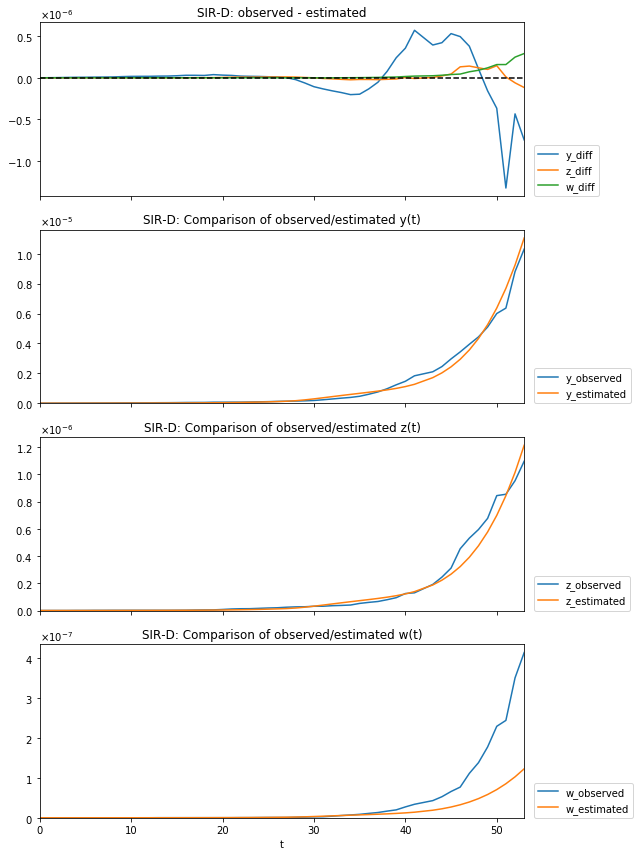

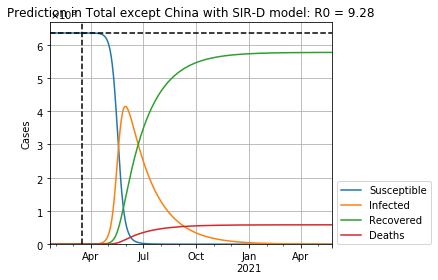

In [17]:
#sird_estimater.history_graph()
pd.DataFrame.from_dict({"SIR": sir_dict, "SIR-D": sird_dict}, orient="index").fillna("-")
sird_estimater.compare_graph()
sird_estimater.predict_graph(step_n=500)

# References

Further Reading

* M. J. Keeling and P. Rohani, <a href="http://press.princeton.edu/titles/8459.html">Modeling Infectious Diseases in Humans and Animals</a>, Princeton (2007).
* R. M. Anderson and R. M. May, <a href="http://www.amazon.co.uk/Infectious-Diseases-Humans-Dynamics-Publications/dp/019854040X">Infectious Diseases of Humans: Dynamics and Control,</a> OUP (1992).